In [76]:
import numpy as np
import pandas as pd
import serial
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
import seaborn as sns
from scipy.optimize import curve_fit

### Define parameters

In [34]:
collection_time = 30        # seconds
max_sample_no = 64500
file_sphygo = "pressure_data.csv"
file_thermi = "temperature_data.csv"
is_report = True

In [35]:
# Initialize serial communication
ser = serial.Serial(port="COM10", baudrate=230400, timeout=1)  # Configure the serial port
ser.flush()  # Flush the serial buffer to clear any existing data

# Function to read ADC value from the serial port
def read_adc_value():
    """
    Reads a single ADC value from the serial port.
    Returns:
        int: The ADC value if successfully read, otherwise None.
    """
    try:
        if ser.in_waiting > 0:  # Check if data is available in the serial buffer
            line = ser.readline().strip()  # Read and decode the line
            line = line.decode('utf-8').split(",")
            data = [int(x) for x in line]
            return data  # Convert the line to an integer
    except ValueError:
        # Ignore invalid data that cannot be converted to an integer
        pass
    return None

# Function to save collected data to a CSV file
def save_to_csv(df, data, filepath):
    """
    Saves the collected data to a CSV file.
    Args:
        data (list): The list of collected ADC values.
        label (int): The class label for the data.
        filepath (str): The name of the CSV file to save the data.
    """
    # Add the new row to the dataframe
    df.loc[len(df)] = data
    # Save the dataframe to a CSV file
    df.to_csv(filepath, index=False)

# Data collection process
therm_init, sphyg_init = [], []
therm_data, sphyg_data = [], []
del_time = 0

try:
    print("Data collection started...")
    activated = False 
    therm_threshold, sphyg_threshold = None, None
    while len(therm_data) <= max_sample_no:
        adc_value = read_adc_value()
        if adc_value is not None and len(adc_value) > 1:
            if therm_threshold is None and sphyg_threshold is None:
                therm_init.append(adc_value[0])
                sphyg_init.append(adc_value[1])
                if len(therm_init) >= 1000:
                    therm_threshold = np.mean(therm_init) + 250
                    sphyg_threshold = np.mean(sphyg_init) + 250
                    print(f"ADC: thermi threshold set at {therm_threshold} | sphygmo threshold set at {sphyg_threshold}")
                    print("Breathe to start!")
                    
            else:
                if not activated and (adc_value[1] >= sphyg_threshold or adc_value[0] >= therm_threshold):
                    activated = True
                    print("First breath detected. Collecting data...")
                    start_time = time.time()
                if activated and 0 <= adc_value[0] <= 4095 and 0 <= adc_value[1] <= 4095:
                    therm_data.append(adc_value[0])
                    sphyg_data.append(adc_value[1])
                    del_time = time.time() - start_time

    print("Data collection completed.")
    data = np.column_stack((therm_data, sphyg_data))
except KeyboardInterrupt:   # Handle manual interruption (Ctrl+C)
    print("Data collection interrupted.")
    data = None

if data is not None:
    try:
        df_therm = pd.read_csv(file_sphygo)  # Try to read the existing CSV file
    except FileNotFoundError:
        # Create a new dataframe with appropriate columns if the file doesn't exist
        df_therm = pd.DataFrame(columns=["data" + str(i + 1) for i in range(len(data))])
    
    try:
        df_sphyg = pd.read_csv(file_thermi)  # Try to read the existing CSV file
    except FileNotFoundError:
        # Create a new dataframe with appropriate columns if the file doesn't exist
        df_sphyg = pd.DataFrame(columns=["data" + str(i + 1) for i in range(len(data))])

    save_to_csv(df_therm, sphyg_data, file_sphygo)  # Save the data with the class label
    save_to_csv(df_sphyg, therm_data, file_thermi)  # Save the data with the class label
    print("Data saved to CSV.")
else:
    print("No data collected.")

# Close the serial port
ser.close()

Data collection started...
ADC: thermi threshold set at 250.0 | sphygmo threshold set at 250.0
Breathe to start!
First breath detected. Collecting data...
Data collection completed.
Data saved to CSV.


In [36]:
if is_report:
    df_therm = pd.read_csv(file_thermi)
    df_sphyg = pd.read_csv(file_sphygo)

    therm_data = df_therm.iloc[-1]
    sphyg_data = df_sphyg.iloc[-1]
    data = np.column_stack((therm_data, sphyg_data))

Text(0.5, 1.0, 'Sphygmomameter ADC Values Over Time')

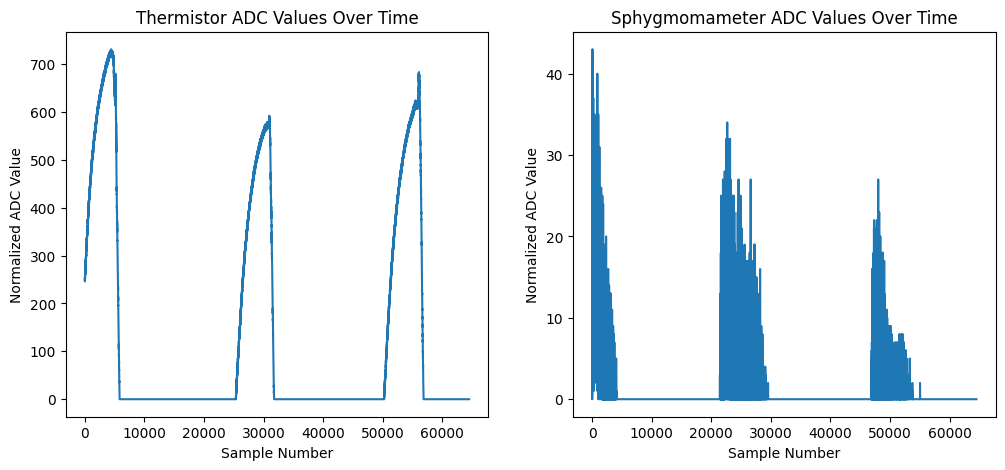

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(data[0])):
    axes[i].plot(range(len(data)), data[:, i])                          # Plot the ADC values
    axes[i].set_xlabel("Sample Number")                                 # Label for the x-axis
    axes[i].set_ylabel("Normalized ADC Value")                          # Label for the y-axis

axes[0].set_title("Thermistor ADC Values Over Time")     # Title of the plot
axes[1].set_title("Sphygmomameter ADC Values Over Time") # Title of the plot

### DSP

C:\Users\Admin\AppData\Local\Temp\ipykernel_16684\535383265.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema[0] = data[0]
C:\Users\Admin\AppData\Local\Temp\ipykernel_16684\535383265.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]


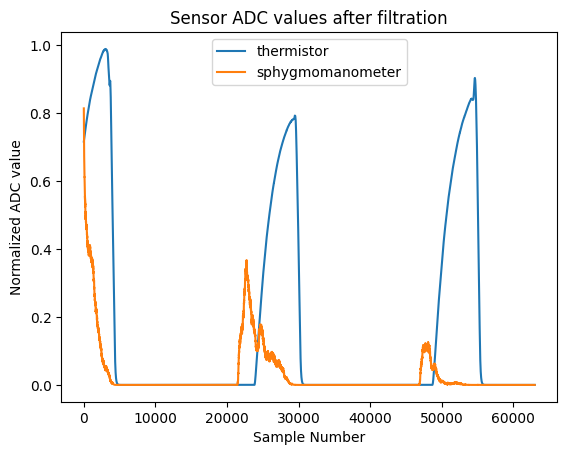

In [38]:
def normalize(arr):
    return (arr - np.mean(arr))/np.std(arr)

def normalize_zero_one(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-8) 

def exponential_moving_average(data, alpha):
    ema = np.zeros_like(data)
    ema[0] = data[0]
   
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
   
    return ema

therm_normed = normalize_zero_one(therm_data)
sphyg_normed = normalize_zero_one(sphyg_data)

therm_ema = exponential_moving_average(therm_normed, 0.01) 
sphyg_ema = exponential_moving_average(sphyg_normed, 0.01) 

therm_ema = therm_ema[1500:]
sphyg_ema = sphyg_ema[:-1500]

plt.plot(range(len(therm_ema)), therm_ema, label="thermistor")
plt.plot(range(len(sphyg_ema)), sphyg_ema, label="sphygmomanometer")
plt.xlabel("Sample Number")
plt.ylabel("Normalized ADC value")
plt.title("Sensor ADC values after filtration")
plt.legend()


### Calculate breath rate

Measured breath rate 4.0 (breaths/min)


Text(0.5, 1.0, 'Combined Sensor ADC values after DSP')

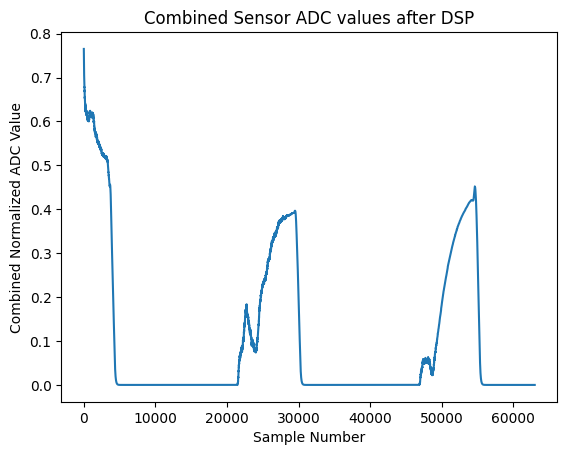

In [39]:
combined_ema = (therm_ema + sphyg_ema) / 2

peaks = find_peaks(combined_ema, height = -0.3, prominence=0.2)[0]
breath_rate = (len(peaks)) / collection_time * 60 
print(f"Measured breath rate {breath_rate} (breaths/min)")

plt.plot(range(len(combined_ema)), combined_ema)
plt.xlabel("Sample Number")
plt.ylabel("Combined Normalized ADC Value")
plt.title("Combined Sensor ADC values after DSP")

### Data collection for JND

In [40]:
# Parameter to change
gain = int(1e6/22e3)
gain

45

In [41]:
filepath = "jnd_data.csv"
ground_truth = 6   # Use the metronome

try:
    df = pd.read_csv(filepath)  # Try to read the existing CSV file
except FileNotFoundError:
    # Create a new dataframe with appropriate columns if the file doesn't exist
    df = pd.DataFrame(columns=['Gain', 'Ground Truth (bmp)', 'System Output (bmp)', 'Correct (1=yes,0=no)'])

# Add the new row to the dataframe
df.loc[len(df)] = [gain, ground_truth, breath_rate, int(ground_truth==breath_rate)]
# Save the dataframe to a CSV file
df.to_csv(filepath, index=False)

#### MSE Plotting

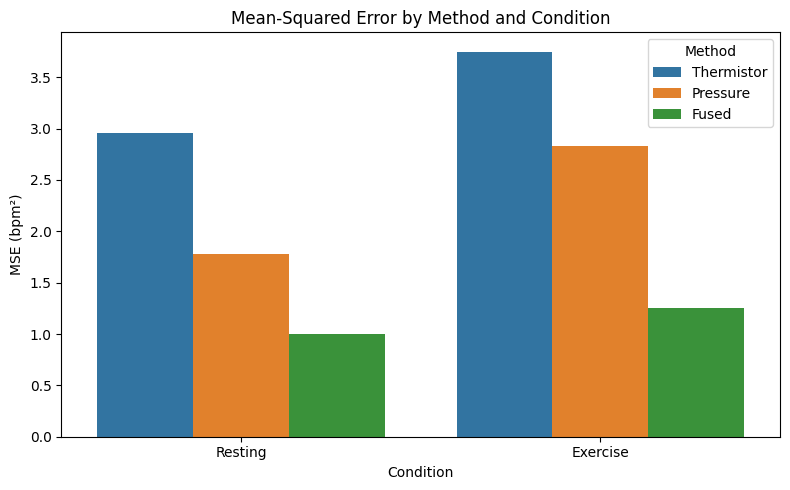

In [89]:
# Load CSVs
mse_df = pd.read_csv("fake_mse_data.csv")

# Plot MSE Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(data=mse_df, x="Condition", y="MSE", hue="Method")
plt.title("Mean-Squared Error by Method and Condition")
plt.ylabel("MSE (bpm²)")
plt.tight_layout()
plt.show()


#### JND Plotting

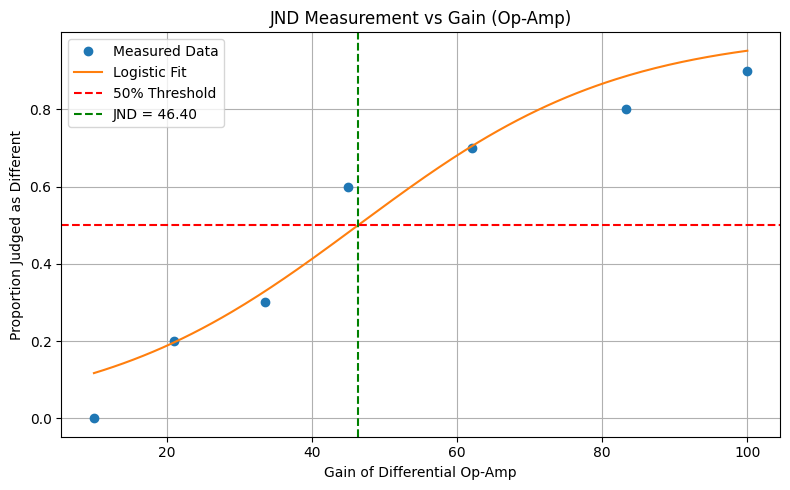

In [85]:
df = pd.read_csv(filepath)

# Group by Gain and calculate mean correctness
grouped = df.groupby("Gain")["Correct (1=yes,0=no)"].mean().reset_index()
grouped.columns = ["Gain", "Proportion Judged as Different"]

# Define logistic function
def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Fit logistic curve to the grouped data
x_data = grouped["Gain"].values
y_data = grouped["Proportion Judged as Different"].values
params, _ = curve_fit(logistic, x_data, y_data, p0=[0.1, 50])
k, x0 = params  # x0 is the estimated JND

# Generate fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = logistic(x_fit, *params)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_data, y_data, 'o', label='Measured Data')
plt.plot(x_fit, y_fit, '-', label='Logistic Fit')
plt.axhline(0.5, color='r', linestyle='--', label='50% Threshold')
plt.axvline(x0, color='g', linestyle='--', label=f'JND = {x0:.2f}')
plt.title("JND Measurement vs Gain (Op-Amp)")
plt.xlabel("Gain of Differential Op-Amp")
plt.ylabel("Proportion Judged as Different")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()